In [1]:
import numpy as np
from scipy import stats
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression 
import tensorflow as tf
import matplotlib.gridspec as gridspec

In [2]:
def Bernoulli(p):
    np.random.seed(int(time.time()))
    if np.random.random()<p :
        return 1
    else :
        return 0
    
def get_Q(P_xy):
    """
    P_xy is the K*n matrix indicating probability p(xi,yi=k)
    return Q is n*1 matrix indicating qi=max(0.5, p(i,1),..., p(i,K))
    
    """
    K, n = np.shape(P_xy)
    Q = np.max(P_xy, axis=0)
    Q[Q<0.5]=0.5
    return Q


def get_A(P_xy, gamma):
    """
    gamma>1 is a parameter
    return A K*n is the sampling probability 改成n*K?
    
    """
    K, n = np.shape(P_xy)
    Q=get_Q(P_xy)
    a = 2*Q/gamma
    a[a>1]=1
    A=np.matrix([a, ]* K)
    A=np.asarray(A)
    idx=np.argmax(P_xy, axis=0)#每一列最大值
    for i in range(0, n):
            if(P_xy[idx[i], i]>=0.5):
                A[idx[i], i]=(1-Q[i])/(gamma-np.max([Q[i], 0.5*gamma]))
    return A.T


def get_Z(P_xy, Y, gamma):
    """
    sample zi~Bernoulli(a(xi, yi): zi=1)
    class label Y is needed, each value yi is in [0, K-1]
    return Z n*1 {0,1} matrix indicating whether to use that sample
    
    """
    n, = Y.shape
    A = get_A(P_xy, gamma)
    Z = np.zeros(n)
    i=0
    for i in range(0,n):
        Z[i]=Bernoulli(A[i, int(Y[i])])
        
    return Z


def get_sample(X, Y, P_xy, gamma):
    """
    subsample X and Y to get training sample and also the corresponding A
    X is n*p
    y is n
    
    """
    Z = get_Z(P_xy, Y, gamma)
    X_sample = X[Z==1, :]
    Y_sample = np.array(Y)[Z==1]
    A = get_A(P_xy, gamma)
    A_sample = A[Z==1, :]
    return X_sample, Y_sample, A_sample

In [4]:
"""
Network architecture
input -> 5*5*32convolution -> 2*2 max pooling -> 5*5*64 convolution -> 2*2 max pooling -> 2*2*1024 -> ReLu -> Likelihood function

"""
learning_rate = 0.0005  # 学习率
batch_size = 128  # 批大小
num_steps = 600  # 使用的样本数量
display_step = 50  # 显示间隔
num_input = 784  # image shape:28*28
num_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # 用于随机丢弃，防止过拟

X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
A = tf.placeholder(tf.float32, [None, num_classes])  # 我们自己的把A加进去
keep_prob = tf.placeholder(tf.float32)
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
# 创建模型
def conv_net(x, weights, biases, dropout):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 32],mean=0,stddev=0.1)),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 32, 64],mean=0,stddev=0.1)),
    # fully connected, 4*4*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([4 * 4 * 64, 1024],mean=0,stddev=0.1)),
    # 1024 inputs, 9 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([1024, num_classes - 1],mean=0,stddev=0.1))
}
biases = {
    'bc1': tf.Variable(tf.truncated_normal([32],mean=0,stddev=0.1)),
    'bc2': tf.Variable(tf.truncated_normal([64],mean=0,stddev=0.1)),
    'bd1': tf.Variable(tf.truncated_normal([1024],mean=0,stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([num_classes - 1],mean=0,stddev=0.1))
} 
# Construct model
logits = conv_net(X, weights, biases, keep_prob)  # (batch_Size, K-1)
G = tf.concat([logits, tf.cast(np.zeros((batch_size, 1)), tf.float32)], axis=1)
temp1 = tf.multiply(G, Y)
temp1 = tf.reduce_sum(temp1, axis=1)
temp1 = tf.reduce_mean(temp1)
temp2 = tf.exp(logits)
temp2 = tf.reduce_sum(temp2, axis=1)
temp2 = tf.add(temp2, 1.0)
temp2 = tf.log(temp2)
temp2 = tf.reduce_mean(temp2)
loss_op = tf.subtract(temp1, temp2)
loss_op = tf.subtract(0.0, loss_op)
pred = tf.argmax(G, 1)
# Define loss and optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Evaluate model
correct_pred = tf.equal(pred, tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.trainable_variables())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


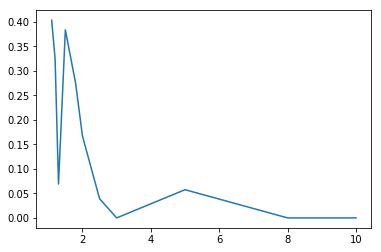

In [6]:
##测试一下gamma与sample数量的关系
#val_label永远保持非one hot的形式，用于训练取样，后来的y_val为one hot形式， 标记一下
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=False)
val_data = mnist.validation.images  #(5000,784)
val_labels = mnist.validation.labels
train_labels = mnist.train.labels
train_data = mnist.train.images
#####
X_train = mnist.train.images
y_train = mnist.train.labels
y_train = np.eye(num_classes)[y_train]
X_val = mnist.validation.images  #(5000,784)
y_val = mnist.validation.labels
y_val = np.eye(num_classes)[y_val]
X_test = mnist.test.images
y_test = mnist.test.labels
y_test = np.eye(num_classes)[y_test]

classifier = LogisticRegression()
classifier.fit(val_data, val_labels)
P_xy = classifier.predict_proba(train_data)
P_xy = P_xy.T
gamma_range = [1.1, 1.2, 1.3, 1.5, 1.8, 2, 2.5, 3, 5, 8, 10]
sample_fraction = np.zeros(11)
for i in range(11):
    X_sample, y_sample, A_sample = get_sample(train_data, train_labels, P_xy, gamma_range[i])
    sample_fraction[i] = y_sample.shape[0]/train_labels.shape[0]
    
plt.plot(gamma_range, sample_fraction)

In [31]:
gamma = 2
classifier = LogisticRegression()
classifier.fit(val_data, val_labels)
P_xy = classifier.predict_proba(train_data)
P_xy = P_xy.T
print(P_xy.shape)
print("accuracy is: ",(1-sum(classifier.predict(train_data)!=train_labels)/train_data.shape[0]))

X_sample, y_sample, A_sample = get_sample(train_data, train_labels, P_xy, gamma)
#print(y_sample[:10])
y_sample = np.eye(num_classes)[y_sample]#数字编码 to one hot, 牛逼


print("# of sample is: ", y_sample.shape[0])


C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(10, 55000)
accuracy is:  0.8907636363636364
# of sample is:  8741


In [32]:
learning_rate = 0.0002  # 学习率
batch_size = 128  # 批大小
num_steps = 500  # 使用的样本数量
display_step = 50  # 显示间隔
num_input = 784  # image shape:28*28
num_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # 用于随机丢弃，防止过拟

def get_batch_from_X(X, y, A, batch_size):
    """
    Get a batch and return the corresponding X_batch, y_batch, A_batch
    """
    data_size = X.shape[0]
    idx = np.random.permutation(data_size)
    X_random = X[idx]
    X_batch = X_random[:batch_size, :]
    y_random = y[idx]
    y_batch = y_random[:batch_size, :]
    A_random = A[idx]
    A_batch = A_random[:batch_size, :]

    return X_batch, y_batch, A_batch

def train():
    sess.run(init)
    for step in range(1, num_steps + 1):
        batch_x, batch_y, batch_A = get_batch_from_X(X_sample, y_sample, A_sample, batch_size)
        # Run optimization op (backprop)
        sess.run(train_op,feed_dict={X: batch_x, Y: batch_y, A: batch_A, keep_prob: dropout})
        #print(np.shape(batch_x),np.shape(batch_y))
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,Y: batch_y,A: batch_A, keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss={:.4f}".format(loss) + ", Training Accuracy={:.3f}".format(acc))


In [33]:
test_accuracy = np.zeros(20)
with tf.Session() as sess:
    train()
    for i in range(20):
        test_accuracy[i] = sess.run(accuracy, feed_dict={X: X_test[i*batch_size : (i+1)*batch_size,:],Y: y_test[i*batch_size : (i+1)*batch_size,:], 
                                        A: np.ones([batch_size, num_classes]), keep_prob: 1.0})
    print("test accuracy over 20 batches is :", np.mean(test_accuracy))

Step 1, Minibatch Loss=3.3199, Training Accuracy=0.133
Step 50, Minibatch Loss=0.8866, Training Accuracy=0.750
Step 100, Minibatch Loss=0.4116, Training Accuracy=0.859
Step 150, Minibatch Loss=0.3175, Training Accuracy=0.922
Step 200, Minibatch Loss=0.2229, Training Accuracy=0.906
Step 250, Minibatch Loss=0.2200, Training Accuracy=0.922
Step 300, Minibatch Loss=0.1557, Training Accuracy=0.953
Step 350, Minibatch Loss=0.2202, Training Accuracy=0.953
Step 400, Minibatch Loss=0.1063, Training Accuracy=0.977
Step 450, Minibatch Loss=0.0862, Training Accuracy=0.984
Step 500, Minibatch Loss=0.0533, Training Accuracy=0.984
test accuracy over 20 batches is : 0.9828125


In [17]:
"""
接下来要做一些实验了，
1.测试一下这个A是不是有用，尝试一次用np.ones训练
2.测试一下取出来的sample在softmax的网络上好不好用
3.对比一下uniform sample, 为了省事直接用test_set代替unifor sample的set

"""

'\n接下来要做一些实验了，\n1.测试一下这个A是不是有用，尝试一次用np.ones训练\n2.测试一下取出来的sample在softmax的网络上好不好用\n3.对比一下uniform sample, 为了省事直接用test_set代替unifor sample的set\n\n'

In [22]:
#首先测试A为1的情况
gamma = 1.5
train_nums = X_train.shape[0]
classifier = LogisticRegression()
classifier.fit(val_data, val_labels)
P_xy = classifier.predict_proba(train_data)
P_xy = P_xy.T
print(P_xy.shape)
print("accuracy is: ",(1-sum(classifier.predict(train_data)!=train_labels)/train_nums))

X_sample, y_sample, A_sample = get_sample(train_data, train_labels, P_xy, gamma)
##改动
A_sample = np.ones_like(A_sample)
#print(y_sample[:10])
y_sample = np.eye(num_classes)[y_sample]#数字编码 to one hot, 牛逼


print("# of sample is: ", y_sample.shape[0])


C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(10, 55000)
accuracy is:  0.8907636363636364
# of sample is:  12785


In [23]:
test_accuracy = np.zeros(20)
with tf.Session() as sess:
    train()
    for i in range(20):
        test_accuracy[i] = sess.run(accuracy, feed_dict={X: X_test[i*batch_size : (i+1)*batch_size,:],Y: y_test[i*batch_size : (i+1)*batch_size,:], 
                                        A: np.ones([batch_size, num_classes]), keep_prob: 1.0})
    print("test accuracy over 20 batches is :", np.mean(test_accuracy))
"""
结论，把训练中的权重A去掉似乎没什么大的影响，应该是因为大部分分类都是准确的，在准确的情况下其他类概率极低
加不加权意义不大
"""

Step 1, Minibatch Loss=2.4192, Training Accuracy=0.219
Step 50, Minibatch Loss=0.7988, Training Accuracy=0.742
Step 100, Minibatch Loss=0.4153, Training Accuracy=0.867
Step 150, Minibatch Loss=0.2280, Training Accuracy=0.938
Step 200, Minibatch Loss=0.1534, Training Accuracy=0.961
Step 250, Minibatch Loss=0.1091, Training Accuracy=0.969
Step 300, Minibatch Loss=0.1011, Training Accuracy=0.961
Step 350, Minibatch Loss=0.1136, Training Accuracy=0.961
Step 400, Minibatch Loss=0.1346, Training Accuracy=0.953
Step 450, Minibatch Loss=0.0485, Training Accuracy=0.992
Step 500, Minibatch Loss=0.0626, Training Accuracy=0.977
Step 550, Minibatch Loss=0.0359, Training Accuracy=0.992
Step 600, Minibatch Loss=0.0445, Training Accuracy=0.977
test accuracy over 20 batches is : 0.983984375


'\n结论，把训练中的权重A去掉似乎没什么大的影响，应该是因为大部分分类都是准确的，在准确的情况下其他类概率极低\n加不加权意义不大\n'

In [164]:
#对比一下随机取样的, 用测试集的1w个样本代替随机抽样
#用val_data来做验证


A_s = np.ones([10000, num_classes])

def train():
    sess.run(init)
    for step in range(1, num_steps + 1):
        batch_x, batch_y, batch_A = get_batch_from_X(X_test, y_test, A_s, batch_size)
        # Run optimization op (backprop)
        sess.run(train_op,feed_dict={X: batch_x, Y: batch_y, A: batch_A, keep_prob: dropout})
        #print(np.shape(batch_x),np.shape(batch_y))
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,Y: batch_y,A: batch_A, keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss={:.4f}".format(loss) + ", Training Accuracy={:.3f}".format(acc))



test_accuracy = np.zeros(20)
with tf.Session() as sess:
    train()
    for i in range(20):
        test_accuracy[i] = sess.run(accuracy, feed_dict={X: X_val[i*batch_size : (i+1)*batch_size,:],Y: y_val[i*batch_size : (i+1)*batch_size,:], 
                                        A: np.ones([batch_size, num_classes]), keep_prob: 1.0})
    print("test accuracy over 20 batches is :", np.mean(test_accuracy))
    
"""
这种情况我们称之为没有什么显著区别
"""

Step 1, Minibatch Loss=3.1488, Training Accuracy=0.328
Step 50, Minibatch Loss=0.1469, Training Accuracy=0.953
Step 100, Minibatch Loss=0.1087, Training Accuracy=0.961
Step 150, Minibatch Loss=0.0431, Training Accuracy=0.984
Step 200, Minibatch Loss=0.0669, Training Accuracy=0.969
Step 250, Minibatch Loss=0.0057, Training Accuracy=1.000
Step 300, Minibatch Loss=0.0067, Training Accuracy=1.000
Step 350, Minibatch Loss=0.0130, Training Accuracy=1.000
Step 400, Minibatch Loss=0.0027, Training Accuracy=1.000
Step 450, Minibatch Loss=0.0018, Training Accuracy=1.000
Step 500, Minibatch Loss=0.0154, Training Accuracy=0.992
Step 550, Minibatch Loss=0.0112, Training Accuracy=0.992
Step 600, Minibatch Loss=0.0044, Training Accuracy=1.000
test accuracy over 20 batches is : 0.98046875


'\n这种情况我们称之为没有什么显著区别\n'

In [34]:
#然后再来测试一下softmax的普通网络,首先是以刚才的sample为data

learning_rate = 0.001 #学习率 
batch_size = 128 #批大小
num_steps = 500 #使用的样本数量
display_step = 50 #显示间隔

num_input = 784 #image shape:28*28
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 #用于随机丢弃，防止过拟

X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)


def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

#创建模型
def conv_net(x, weights, biases, dropout):

    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)
pred = tf.argmax(prediction, 1)
# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(pred, tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.trainable_variables())

def train():
    sess.run(init)
    for step in range(1,num_steps+1):
        batch_x, batch_y, A_ = get_batch_from_X(X_sample, y_sample, A_sample, batch_size)
        # Run optimization op (backprop)
        
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss={:.4f}".format(loss) + ", Training Accuracy={:.3f}".format(acc))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [35]:
test_accuracy = np.zeros(20)
with tf.Session() as sess:
    train()
    for i in range(20):
        test_accuracy[i] = sess.run(accuracy, feed_dict={X: X_test[i*batch_size : (i+1)*batch_size,:],Y: y_test[i*batch_size : (i+1)*batch_size,:], 
                                         keep_prob: 1.0})
    print("test accuracy over 20 batches is :", np.mean(test_accuracy))
"""
我们的sample在softmax的cnn上效果不是很好
"""

Step 1, Minibatch Loss=116257.7812, Training Accuracy=0.141
Step 50, Minibatch Loss=11684.4277, Training Accuracy=0.391
Step 100, Minibatch Loss=5451.6616, Training Accuracy=0.602
Step 150, Minibatch Loss=4455.7188, Training Accuracy=0.633
Step 200, Minibatch Loss=3002.9951, Training Accuracy=0.734
Step 250, Minibatch Loss=1931.1198, Training Accuracy=0.750
Step 300, Minibatch Loss=1696.3761, Training Accuracy=0.805
Step 350, Minibatch Loss=1672.2264, Training Accuracy=0.781
Step 400, Minibatch Loss=866.7910, Training Accuracy=0.883
Step 450, Minibatch Loss=758.6470, Training Accuracy=0.867
Step 500, Minibatch Loss=571.1488, Training Accuracy=0.914
test accuracy over 20 batches is : 0.909375


'\n我们的sample在softmax的cnn上效果不是很好\n'

In [36]:
X_sample.shape

(8741, 784)

In [39]:
##最后来测试一下softmax方法在整个train_data上的表现
learning_rate = 0.002 #学习率 
batch_size = 128 #批大小
num_steps = 600 #使用的样本数量
display_step = 50 #显示间隔

def get_batch_from_X1(X, y, batch_size):
    """
    Get a batch and return the corresponding X_batch, y_batch, A_batch
    """
    data_size = X.shape[0]
    idx = np.random.permutation(data_size)
    X_random = X[idx]
    X_batch = X_random[:batch_size, :]
    y_random = y[idx]
    y_batch = y_random[:batch_size, :]

    return X_batch, y_batch


def train():
    sess.run(init)
    for step in range(1,num_steps+1):
        batch_x, batch_y = get_batch_from_X1(X_train, y_train, batch_size)
        # Run optimization op (backprop)
        
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss={:.4f}".format(loss) + ", Training Accuracy={:.3f}".format(acc))
            
            
            
test_accuracy = np.zeros(20)
with tf.Session() as sess:
    train()
    for i in range(20):
        test_accuracy[i] = sess.run(accuracy, feed_dict={X: X_test[i*batch_size : (i+1)*batch_size,:],Y: y_test[i*batch_size : (i+1)*batch_size,:], 
                                         keep_prob: 1.0})
    print("test accuracy over 20 batches is :", np.mean(test_accuracy))

Step 1, Minibatch Loss=53995.3438, Training Accuracy=0.109
Step 50, Minibatch Loss=3166.9705, Training Accuracy=0.789
Step 100, Minibatch Loss=1451.3317, Training Accuracy=0.898
Step 150, Minibatch Loss=1777.3933, Training Accuracy=0.914
Step 200, Minibatch Loss=788.7242, Training Accuracy=0.953
Step 250, Minibatch Loss=1242.3369, Training Accuracy=0.906
Step 300, Minibatch Loss=1117.7108, Training Accuracy=0.906
Step 350, Minibatch Loss=270.5781, Training Accuracy=0.961
Step 400, Minibatch Loss=414.4936, Training Accuracy=0.953
Step 450, Minibatch Loss=1155.4604, Training Accuracy=0.914
Step 500, Minibatch Loss=464.8482, Training Accuracy=0.969
Step 550, Minibatch Loss=607.9376, Training Accuracy=0.938
Step 600, Minibatch Loss=458.8017, Training Accuracy=0.938
test accuracy over 20 batches is : 0.9421875
